In [4]:
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
import numpy as np
from pandas_summary import DataFrameSummary
import pandas_profiling as pp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import random
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
import graphviz 
from sklearn import tree
%matplotlib inline

In [ ]:
from dateutil.parser import parse
train_set_df = pd.read_csv("train_set.csv", parse_dates = ['timestamp'], date_parser = parse )
test_set_df = pd.read_csv("test_set.csv", parse_dates = ['timestamp'], date_parser = parse )

In [ ]:
y_train_raw = train_set_df.label
train_set_grouped_by_patients = train_set_df.groupby('patient_id')

# EDA

**Initial examination of the raw data**

In [25]:
train_set_df.describe()

_temporary_index_column     patient_id  measurement_x  measurement_y  \
count            799999.000000  799999.000000  799999.000000  799999.000000   
mean             400000.000000   12848.728287       0.652244       0.148045   
std              230939.963337    7418.937484       0.241065       0.204066   
min                   1.000000       0.000000      -0.621091      -1.045211   
25%              200000.500000    6378.000000       0.478952       0.016042   
50%              400000.000000   12830.000000       0.611564       0.128319   
75%              599999.500000   19275.000000       0.797053       0.252838   
max              799999.000000   25705.000000       1.905430       1.506080   

       measurement_z          label  
count  799999.000000  799999.000000  
mean        0.073163       0.439943  
std         0.059840       0.691995  
min        -0.004350       0.000000  
25%         0.033487       0.000000  
50%         0.058148       0.000000  
75%         0.094124       1.000000  
max         0.478850       2.000000

**The distribution of labels over the raw data is approx: 68% - class 0, 20% - class 1, and 12% - class 2**

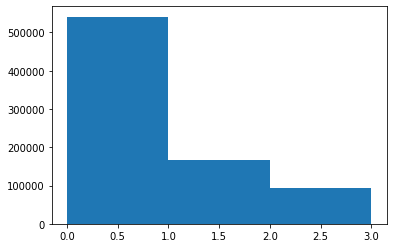

In [26]:
counts = plt.hist(y_train_raw, bins =  [0,1,2,3] )

In [27]:
counts[0]/counts[0].sum()*100

array([67.62883454, 20.74802594, 11.62313953])

**The labels are attributes of patients, not of specific samples (all patient's samples have the same label )** 

In [28]:
inds_0 = y_train_raw==0
inds_1 = y_train_raw==1
inds_2 = y_train_raw==2

In [29]:
patiends_0_set = set(train_set_df[inds_0]['patient_id'])
patiends_1_set = set(train_set_df[inds_1]['patient_id'])
patiends_2_set = set(train_set_df[inds_2]['patient_id'])

In [30]:
patiends_0_set.intersection(patiends_1_set)

set()

In [31]:
patiends_0_set.intersection(patiends_2_set)

set()

In [32]:
patiends_1_set.intersection(patiends_2_set)

set()

**Each patient's data consists of 3 time series. The number of samples in these series across the patients varies between 1 (single sample) and nearly 100**

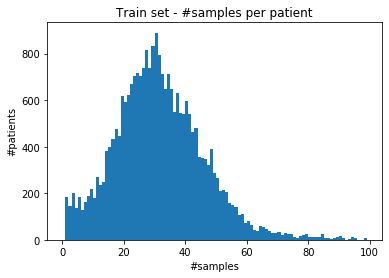

In [33]:
train_set_samples_sizes = [len(pdf[1]) for pdf in train_set_grouped_by_patients]
plt.hist(train_set_samples_sizes, bins = np.arange(0,100));
plt.title("Train set - #samples per patient");
plt.xlabel("#samples");
plt.ylabel("#patients");

**The test set has similar distribution, which means, in particular, that we'll need to predict labels of series consisting of a single time sample**

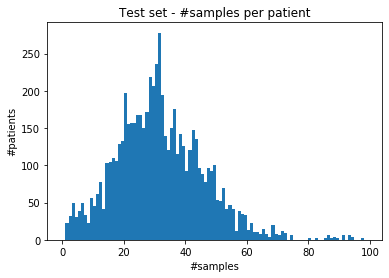

In [34]:
test_set_samples_sizes = [len(pdf[1]) for pdf in test_set_df.groupby('patient_id')]
plt.hist(test_set_samples_sizes, bins = np.arange(0,100));
plt.title("Test set - #samples per patient");
plt.xlabel("#samples");
plt.ylabel("#patients");

**Since the timedelta between each sample is 50ms, the corresponding series durations vary between 0 sec (single sample) to nearly 5 sec (100 samples)** 

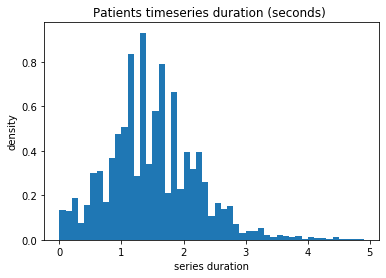

In [35]:
train_set_samples_durations = [(pdf[1]['timestamp'].iloc[-1] - pdf[1]['timestamp'].iloc[0]).total_seconds() for pdf in train_set_grouped_by_patients]
plt.hist(train_set_samples_durations, density=True, bins = np.arange(0, 5, 0.1));
plt.title("Patients timeseries duration (seconds) ");
plt.xlabel("series duration");
plt.ylabel("density");

**Some series are inconsistent in terms of their sizes and durations. Below we see some series with 5 samples (corresponding to 0.2 sec), whose duration is less than 0.2 sec** 

In [36]:
np.array(train_set_samples_durations)[np.array(train_set_samples_sizes)==5]

array([0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.15, 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.15, 0.15,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.15, 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.15, 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.15, 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.  , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.15, 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.

**Let's find the one with duration 0**

In [37]:
np.argmax((np.array(train_set_samples_sizes)==5) & (np.array(train_set_samples_durations) < 0.05))

18186

In [38]:
train_set_grouped_by_patients.get_group(18186)

_temporary_index_column                  timestamp  measurement_x  \
566557                   566558 2015-01-02 09:08:28.683331       0.925543   
566558                   566559 2015-01-02 09:08:28.683331       0.928349   
566559                   566560 2015-01-02 09:08:28.683331       0.931236   
566560                   566561 2015-01-02 09:08:28.683331       0.934203   
566561                   566562 2015-01-02 09:08:28.683331       0.937251   

        measurement_y  measurement_z  label  
566557      -0.028669       0.097464      1  
566558      -0.038518       0.101493      1  
566559      -0.048345       0.104182      1  
566560      -0.058147       0.107254      1  
566561      -0.067925       0.110500      1

**The timestamps are identical across all the samples. Here's another example:**

In [39]:
train_set_grouped_by_patients.get_group(np.argmax((np.array(train_set_samples_sizes)==5) & (np.array(train_set_samples_durations) == 0.1)))

_temporary_index_column                  timestamp  measurement_x  \
691313                   691314 2013-08-20 16:42:45.478373       0.934248   
691314                   691315 2013-08-20 16:42:45.478373       0.937080   
691315                   691316 2013-08-20 16:42:45.578373       0.939844   
691316                   691317 2013-08-20 16:42:45.578373       0.942538   
691317                   691318 2013-08-20 16:42:45.578373       0.945163   

        measurement_y  measurement_z  label  
691313       0.226638       0.053605      1  
691314       0.233343       0.057909      1  
691315       0.240076       0.058216      1  
691316       0.246837       0.060546      1  
691317       0.253626       0.064965      1

**Seems that the measurements behave properly (they are not constant in time), thus it's a bug in the timestamps registration. We can either remove such samples as outliers or fix their timestamps based on their number of samples.
In order to decide between the options, let's see home many patients have this discrepancy, and of which type**

In [40]:
all_inconsistent_indices = ((np.array(train_set_samples_sizes) - 1)*0.05 - np.array(train_set_samples_durations)) > 0.00001
print(f"there are {all_inconsistent_indices.sum()} patients whose time series duration is shorter than their 50ms*#samples")
all_inconsistent_indices_upper = ((np.array(train_set_samples_sizes) - 1)*0.05 - np.array(train_set_samples_durations)) < - 0.00001
print(f"there are {all_inconsistent_indices_upper.sum()} patients whose time series duration is longer than their 50ms*#samples")

there are 2527 patients whose time series duration is shorter than their 50ms*#samples
there are 0 patients whose time series duration is longer than their 50ms*#samples


**This is more than 10% - we don't want to just throw them away. We also see that the duration is bounded by 50ms*#samples. So I'll go with the second option - correcting the timestamps. This will be done when extracting the features**


## TimeSeries - acquaintance 

**Since the class is a property of the patient (rather than a sample), let's examine the per-patient classes.**

**The classes proportions remain similar to the raw samples ones.**

there are 25706 patients altogether


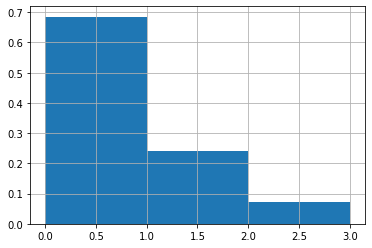

In [41]:
patients_classes_df = train_set_grouped_by_patients.nth(0)['label']
print(f"there are {len(patients_classes_df)} patients altogether")
patients_classes_df.hist(bins=[0,1,2,3], density=True);
y_per_patient = patients_classes_df.values

**Some utility functions for visualiation**

In [42]:
#Plot a patient timeseries, optionally with the regressed approximations superimposed (this comes later on)
def plot_patient_lines(patient_id, extracted_features = None, plot_ax = None):
    if plot_ax is None:
        fig_p, ax_p = plt.subplots()
    else:
        ax_p = plot_ax
    
    curr_patient_df = train_set_grouped_by_patients.get_group(patient_id)
    first_timestamp = curr_patient_df['timestamp'].iloc[0]
    curr_patient_df.index = list(map(lambda ts : (ts -first_timestamp).total_seconds()*1000, curr_patient_df['timestamp']))
    curr_patient_df[['measurement_x', 'measurement_y', 'measurement_z']].plot(ax=ax_p)
    if extracted_features is not None:
        coefs = extracted_features.reshape(3,3).T
        x_regr = curr_patient_df.index.values
        x_mat = np.array([np.ones(len(x_regr)), x_regr, x_regr*x_regr ]).T
        curr_patient_df_approx = pd.DataFrame( x_mat.dot(coefs), 
                                              columns = ['measurement_x_regr', 'measurement_y_regr', 'measurement_z_regr'], 
                                                index = curr_patient_df.index
                                             )
        curr_patient_df_approx[['measurement_x_regr', 'measurement_y_regr', 'measurement_z_regr']].plot(ax=ax_p, style='--')
    ax_p.set_title(f"Patient {patient_id} timeseries")
    ax_p.set_xlabel("time from first timestamp (ms)")
    return len(curr_patient_df), ax_p

#Choose n_patient random patients of class patient_class
def choose_rand_patients( n_patients, patient_class ):
    if patient_class not in [0,1,2]:
        raise Exception("Specified patient_class is not in existing classes set: [0,1,2]")
    patient_class_inds = y_per_patient==patient_class
    num_class_patients = sum(patient_class_inds)
    if n_patients > num_class_patients:
        raise Exception("Specified num samples {} exceeds the number of patients of requested class {}".format(n_patients, patient_class))
    selected_class_inds = random.sample(range(0, num_class_patients), n_patients)
    selected_patients = patients_classes_df[patient_class_inds].index[selected_class_inds]
    return selected_patients.values



**Let's view some timeseries of each of the classes**

(43, <matplotlib.axes._subplots.AxesSubplot at 0xae89610508>)

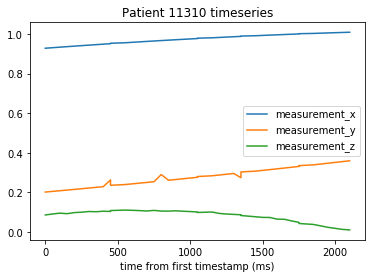

In [43]:
patients_ids = choose_rand_patients(1,1)
plot_patient_lines(patients_ids[0])

**Typical and less typical classes timeseries**

Based on sproradic visual inspection of the timelines. Left images are the more typical, right ones seems less typical to each class.  

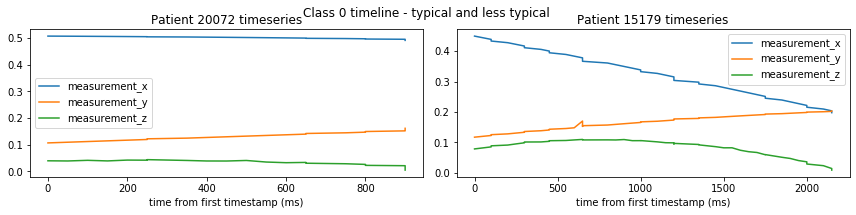

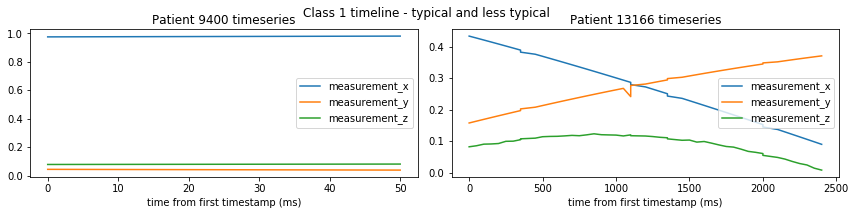

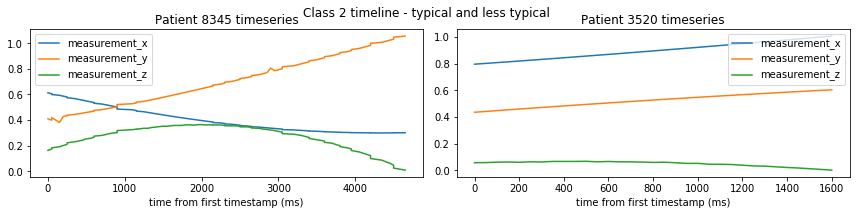

In [44]:
fig_0, (ax_0_typical, ax_0_non_typical) = plt.subplots(1,2)
fig_0.set_size_inches(12, 3)
plot_patient_lines(20072, plot_ax=ax_0_typical)
plot_patient_lines(15179, plot_ax=ax_0_non_typical)
fig_0.suptitle("Class 0 timeline - typical and less typical \n")
plt.tight_layout()

fig_1, (ax_1_typical, ax_1_non_typical) = plt.subplots(1,2)
fig_1.set_size_inches(12, 3)
plot_patient_lines(9400, plot_ax=ax_1_typical)
plot_patient_lines(13166, plot_ax=ax_1_non_typical)
fig_1.suptitle("Class 1 timeline - typical and less typical \n")
plt.tight_layout()

fig_2, (ax_2_typical, ax_2_non_typical) = plt.subplots(1,2)
fig_2.set_size_inches(12, 3)
fig_2.suptitle("Class 2 timeline - typical and less typical \n")
plot_patient_lines(8345, plot_ax=ax_2_typical)
plot_patient_lines(3520, plot_ax=ax_2_non_typical) 
plt.tight_layout()


**Intermediate summary**

- Each patient is characterized by his/her 3 timeseries.  
- Visual inspection indicates that each class has a typical footprint in terms of its signals and their mutual configuration.
- A reasonable direction would be to represent each signal as a 1st or 2nd order polynomial, and use the coefficient as the features set for each patient.
- We can possibly add more features - e.g. whether or not signals intersect (typical to class 2), the average distance between signals (typically the y and z signals in class 1 are close), zero (or other level) crossing, etc. But let's start as simple as possible.

# Features engineering

In [45]:
# Utility functions to generate the features. 
extraction_schemes = ['parabola']
ts_handling_scheme = ['use_ts', 'create_x']
def extract_signals_params(signals_df, extraction_scheme, ts_handling_scheme):
   
    timestamps = signals_df.loc[:, 'timestamp']
   
    first_timestamp =  timestamps.iloc[0]
    if ts_handling_scheme == 'use_ts':
        x = np.array(list(map(lambda ts : (ts -first_timestamp).total_seconds()*1000, timestamps)))
    else:
        x = np.arange(0, len(timestamps)*50, 50) 
           
    x = np.array([x, x*x]).T #When the extraction_schemt is 'parabole', actually.
    sigs =  signals_df.loc[:, ['measurement_x', 'measurement_y', 'measurement_z']].values
    #Regress each signal to a 2nd order polynomial
    reg = LinearRegression().fit(x, sigs )
    #Explicitly adding the intial value is redundant, since x starts at 0, hence the intercept is just this initial value
    return list(np.concatenate((np.array([reg.intercept_]).T, reg.coef_), axis=1).reshape(1,-1)[0])
    
    
def extract_single_patient_features( patient_df, extraction_scheme, ts_handling_scheme ):
    patient_id = patient_df['patient_id'].iloc[0]
    patient_features = []
    curr_line_params = extract_signals_params(patient_df, extraction_scheme, ts_handling_scheme)
    patient_features += curr_line_params
    return patient_features
        
    
def extract_features(in_df, extraction_scheme='parabola', ts_handling_scheme='use_ts'):
    #TODO: input sanity checks
    X = []
    y = []
    for _,patient_df in in_df.groupby('patient_id'):
        extracted_features = extract_single_patient_features( patient_df, extraction_scheme, ts_handling_scheme )
        X.append(extracted_features )
        if 'label' in patient_df:
            y.append(patient_df['label'].iloc[0])
    features_names = ['meas_{}_a{}'.format(i,j) for i in ['x', 'y', 'z'] for j in range(3)]
    return np.array(X), np.array(y), features_names



In [46]:
# 'create_x' means we ignore the actual timestamps and use 50ms intervals between each successive samples.
X, y, features_names  = extract_features(train_set_df, ts_handling_scheme='create_x')


**Let's check how well this model encodes the timeseries**

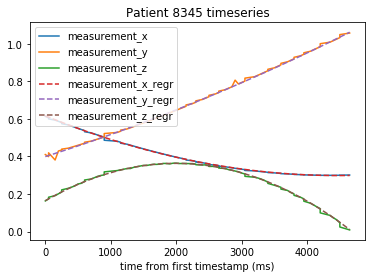

In [13]:
plot_patient_lines(8345, X[8345,:]);

**Visualize $X|y$, just to get a feeling of how well the features are seperable.**

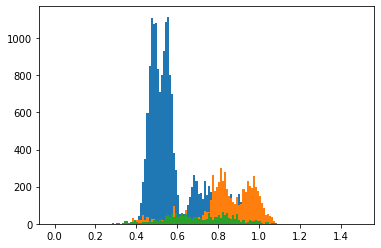

In [47]:
x_0 = X[ y==0, :]
x_1 = X[ y==1, :]
x_2 = X[ y==2, :]
# len(x_0)
fig_x_given_y, ax_x_given_y = plt.subplots()
bins_f8 = np.arange(-0.0000001, 0.00000001, 0.000000001)
bins_f0 = np.arange(0, 1.5, 0.01)
bins_f2 = np.arange(-0.00000004, 0.00000004, 0.000000001)
bins_f3 = np.arange(-0.2, 0.6, 0.01)
ax_x_given_y.hist(x_0[:,0], bins=bins_f0);
ax_x_given_y.hist(x_1[:,0], bins=bins_f0);
ax_x_given_y.hist(x_2[:,0], bins=bins_f0);



**3d visualization (3 same order coefficients of the timeseries) indicate that classes 0, 1 are more seperable than class 2.** 

In [48]:
import plotly.express as px
i=2
j=5
k=8

def plot_3d_features(i, j, k, title):
    fig = go.Figure(data=[go.Scatter3d(x= x_0[:,i], y=x_0[:,j], z=x_0[:,k],
                                       mode='markers', name='class 0', 
                                       marker=dict(
                                        size=2,
                                        opacity=0.6
                                    ))])
    fig.add_trace( go.Scatter3d(x= x_1[:,i], y=x_1[:,j], z=x_1[:,k],
                                       mode='markers', name='class 1', 
                                       marker=dict(
                                        size=2,
                                        opacity=0.6
                                    )))

    fig.add_trace( go.Scatter3d(x= x_2[:,i], y=x_2[:,j], z=x_2[:,k],
                                       mode='markers', name='class 2', 
                                       marker=dict(
                                        size=2,
                                        opacity=0.6
                                    )))
    fig.update_layout(
        title={
            'text': title,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
    fig.show()

plot_3d_features(0, 3, 6,  "3 classes ts 0nd order coefficient")
plot_3d_features(2, 5, 8,  "3 classes ts 2nd order coefficient")



# Classification

In [49]:
#Scaling is mainly for the SVM. Trees don't need it.
X_train, X_test, y_train, y_test, inds_train, inds_test = train_test_split(X, y, np.arange(len(y)), test_size = 0.2)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
#Verify the classes proportions remain.
print("Classes proportions in train set: 0:{}, 1:{}, 2:{}".format((y_train == 0).sum()/len(y_train), 
                                                                  (y_train == 1).sum()/len(y_train), 
                                                                  (y_train == 2).sum()/len(y_train)))


Classes proportions in train set: 0:0.6861991830383194, 1:0.2412468391363548, 2:0.07255397782532581


**Find optimal meta parameters**

In [18]:
class ClassifierContainer:
    # Long_params_list - a wide range to examine.
    # short_params_list - reduced one based on wide range examination (to reduce runtime when executing)
    # short_params_list_over_entire_train - used for sanity tests over the entire train set.
    def __init__(self, clf, long_params_list, short_params_list, short_params_list_over_entire_train):
        self.clf = clf
        self.long_params_list = long_params_list
        self.short_params_list = short_params_list
        self.short_params_list_over_entire_train = short_params_list_over_entire_train
        
    
        
classifiers_dict = {
    'svm': ClassifierContainer(SVC(),
                    [{'kernel': ['rbf'], 'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30],
                     'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 700, 800, 1000, 1200, 1500]},
                    {'kernel': ['linear'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]}
                    ], 
                    [{'kernel': ['rbf'], 'gamma': [ 1],
                     'C': [300, 500, 700, 1000]}
                    ], 
                    [{'kernel': ['rbf'], 'gamma': [ 0.03 ],
                     'C': [300, 500]}
                    ]
            ), 
                            
    'random_forest' : ClassifierContainer(RandomForestClassifier(), 
                           [{ 'n_estimators' : [100, 200, 500, 1000, 1200, 1500],
                              'max_depth': [ 10, 20, 30, 40, 50, 60, 100], 
                              'class_weight' :['balanced'] }
                           ], 
                            [{ 'n_estimators' : [ 500, 600],
                              'max_depth': [ 30, 40 ], 
                              'class_weight' :['balanced'] }
                           ], 
                            [{ 'n_estimators' : [ 1000, 1200],
                              'max_depth': [ 60 ], 
                              'class_weight' :['balanced'] }
                           ]
                    ),
    
    'xgboost' : ClassifierContainer( xgb.XGBClassifier(), 
                           [{ 'reg_lambda' : [10, 30, 100], #[0.1, 0.3, 1, 3, 10, 30, 100, 300],
                              'max_depth': [5, 7, 10, 20, 30], #[ 10, 20, 30, 40, 50, 60, 100], 
                              'n_estimators' : [100, 200, 500, 800, 1000],
                              'n_jobs' : [5]
                               }
                           ], 
                             [{ 'reg_lambda' : [ 10 ],
                                'max_depth': [ 7], 
                               'n_jobs' : [5], 
                               'n_estimators' :[1000]
                               }
                           ], 
                             [{ 'reg_lambda' : [ 30 ],
                                'max_depth': [ 20], 
                               'n_jobs' : [5]
                               }
                           ]
                    )
         
}

In [19]:
def find_optimal_meta_parameters(train_x, train_y, classifier, tuned_parameters_dict, score='f1'):
    
    scores = [score]
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(
           classifier, tuned_parameters_dict, scoring='%s_macro' % score, 
            verbose=10, 
            n_jobs=6
        )
        clf.fit(train_x, train_y)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    return clf.best_estimator_


In [20]:
# Tune each of the considered classifiers, and store the one with highest performance in tuned_classifiers
list_to_tune_options = ['long', 'short', 'short_on_all']
list_to_tune = 'short'
tuned_classifiers = {}
for clfname in classifiers_dict:
    print( "\n ############## Tuning meta parameters for classifier {} ########### \n".format(clfname))
    clf_params_to_tune = classifiers_dict[clfname]
    if list_to_tune == 'long':
        params_to_tune = clf_params_to_tune.long_params_list
    elif list_to_tune == 'short':
        params_to_tune = clf_params_to_tune.short_params_list
    elif list_to_tune == 'short_on_all':
        params_to_tune = clf_params_to_tune.short_params_list_over_entire_train
    else:
        print("list_to_tune {} is not valid!".format(list_to_tune))
        
    curr_best_estimator = find_optimal_meta_parameters(X_train_scaled, y_train, clf_params_to_tune.clf, 
                                 params_to_tune ,
                                 score='f1')
    tuned_classifiers[clfname] = curr_best_estimator




 ############## Tuning meta parameters for classifier svm ########### 

# Tuning hyper-parameters for f1

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   11.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   12.7s
[Parallel(n_jobs=6)]: Done  12 out of  20 | elapsed:   23.2s remaining:   15.5s
[Parallel(n_jobs=6)]: Done  15 out of  20 | elapsed:   33.3s remaining:   11.0s
[Parallel(n_jobs=6)]: Done  18 out of  20 | elapsed:   33.5s remaining:    3.6s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:   37.7s finished


Best parameters set found on development set:

{'C': 500, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:

0.989 (+/-0.005) for {'C': 300, 'gamma': 1, 'kernel': 'rbf'}
0.990 (+/-0.005) for {'C': 500, 'gamma': 1, 'kernel': 'rbf'}
0.990 (+/-0.005) for {'C': 700, 'gamma': 1, 'kernel': 'rbf'}
0.990 (+/-0.005) for {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}


 ############## Tuning meta parameters for classifier random_forest ########### 

# Tuning hyper-parameters for f1

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   44.1s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   53.2s
[Parallel(n_jobs=6)]: Done  12 out of  20 | elapsed:  1.6min remaining:  1.1min
[Parallel(n_jobs=6)]: Done  15 out of  20 | elapsed:  2.3min remaining:   45.6s
[Parallel(n_jobs=6)]: Done  18 out of  20 | elapsed:  2.4min remaining:   16.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:  2.8min finished


Best parameters set found on development set:

{'class_weight': 'balanced', 'max_depth': 30, 'n_estimators': 600}

Grid scores on development set:

0.997 (+/-0.002) for {'class_weight': 'balanced', 'max_depth': 30, 'n_estimators': 500}
0.997 (+/-0.002) for {'class_weight': 'balanced', 'max_depth': 30, 'n_estimators': 600}
0.996 (+/-0.002) for {'class_weight': 'balanced', 'max_depth': 40, 'n_estimators': 500}
0.997 (+/-0.002) for {'class_weight': 'balanced', 'max_depth': 40, 'n_estimators': 600}


 ############## Tuning meta parameters for classifier xgboost ########### 

# Tuning hyper-parameters for f1

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=6)]: Done   3 out of   5 | elapsed:  2.0min remaining:  1.3min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:  2.0min finished


Best parameters set found on development set:

{'max_depth': 7, 'n_estimators': 1000, 'n_jobs': 5, 'reg_lambda': 10}

Grid scores on development set:

0.998 (+/-0.002) for {'max_depth': 7, 'n_estimators': 1000, 'n_jobs': 5, 'reg_lambda': 10}



In [21]:
tuned_classifiers

{'svm': SVC(C=500, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
     probability=False, random_state=None, shrinking=True, tol=0.001,
     verbose=False),
 'random_forest': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                        criterion='gini', max_depth=30, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=600,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 'xgboost': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learnin

In [22]:
def plot_features_importances(importances):
    plt.figure(figsize=(12, 3))
    plt.title("Feature importances")
    indices = np.argsort(importances)[::-1]
    plt.bar(range(len(importances)), importances[indices],
            color="r",align="center")
    plt.xticks(range(len(importances)), np.array(features_names)[indices])
    plt.xlim([-1, len(importances)])
    plt.show()



################# cassification report for classifier svm ################

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3554
           1       1.00      1.00      1.00      1226
           2       1.00      0.99      1.00       362

    accuracy                           1.00      5142
   macro avg       1.00      1.00      1.00      5142
weighted avg       1.00      1.00      1.00      5142


 Confusion matrix (Wikipedia format):

[[3550    0    0]
 [   4 1226    2]
 [   0    0  360]]

 Confusion matrix (sklearn (transposed) format):



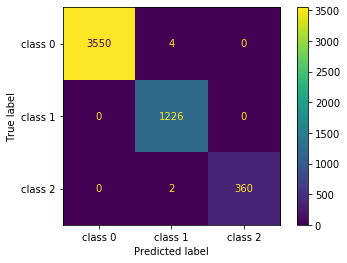

Can't produce feature importance for classifier svm

##################################################################################



################# cassification report for classifier random_forest ################

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3554
           1       1.00      1.00      1.00      1226
           2       1.00      1.00      1.00       362

    accuracy                           1.00      5142
   macro avg       1.00      1.00      1.00      5142
weighted avg       1.00      1.00      1.00      5142


 Confusion matrix (Wikipedia format):

[[3550    0    0]
 [   4 1226    0]
 [   0    0  362]]

 Confusion matrix (sklearn (transposed) format):



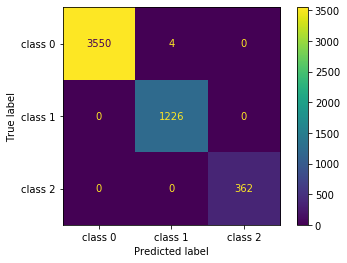

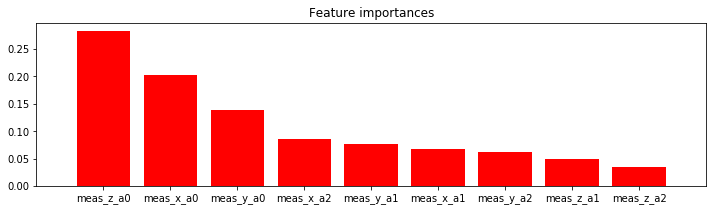


##################################################################################



################# cassification report for classifier xgboost ################

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3554
           1       1.00      1.00      1.00      1226
           2       1.00      1.00      1.00       362

    accuracy                           1.00      5142
   macro avg       1.00      1.00      1.00      5142
weighted avg       1.00      1.00      1.00      5142


 Confusion matrix (Wikipedia format):

[[3550    0    0]
 [   4 1226    0]
 [   0    0  362]]

 Confusion matrix (sklearn (transposed) format):



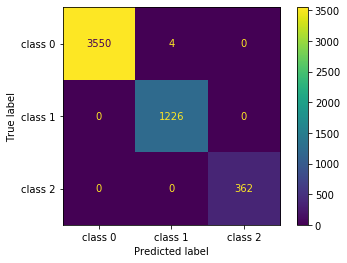

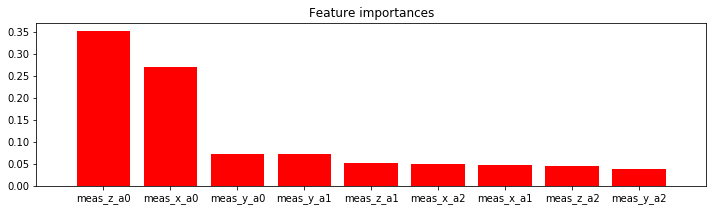


##################################################################################

The classifier with the maximal minimal f1 score is xgboost


In [23]:
#Summarize the performance of each of the tuned classifiers, and find the one with max-min F1 score.
from sklearn.metrics import plot_confusion_matrix
min_f1 = {}
curr_figsize = plt.rcParams['figure.figsize']
for clfname in tuned_classifiers:
    print()
    print( "\n################# cassification report for classifier {} ################\n".format(clfname))
    clf = tuned_classifiers[clfname]
    y_true, y_pred = y_test, clf.predict(X_test_scaled)
    print( classification_report(y_true, y_pred) )
    print("\n Confusion matrix (Wikipedia format):\n")
    print(confusion_matrix(y_true, y_pred, labels=[0,1,2]).T) 
    print("\n Confusion matrix (sklearn (transposed) format):\n")
    plot_confusion_matrix(clf, X_test_scaled, y_true, display_labels=['class 0', 'class 1', 'class 2'], values_format='.0f')
    plt.show()
    if hasattr(clf, 'feature_importances_'):
        plot_features_importances( clf.feature_importances_)
    else:
        print("Can't produce feature importance for classifier {}".format(clfname))
        
    min_f1[clfname] = np.min(f1_score(y_true, y_pred, average=None))
    print("\n##################################################################################\n")
    
sorted_clfnames_by_scores = [k for k, v in sorted(min_f1.items(), key=lambda item: item[1])]
best_classifier = tuned_classifiers[sorted_clfnames_by_scores[-1]]
print("The classifier with the maximal minimal f1 score is {}".format(sorted_clfnames_by_scores[-1]))

In [52]:
best_classifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=5,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [53]:
min_f1

{'svm': 0.9972299168975068,
 'random_forest': 0.998371335504886,
 'xgboost': 0.998371335504886}

**###################### Additions after submissions ####################**

In [15]:
tuned_classifiers['random_forest'].

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:


dot_data = tree.export_graphviz(tuned_classifiers['random_forest'].estimators_[0], out_file=None, 
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("estimator_0")

'estimator_0.pdf'

In [24]:
dot_data = tree.export_graphviz(tuned_classifiers['random_forest'].estimators_[100], out_file=None, 
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("estimator_100")

'estimator_100.pdf'

In [21]:
X_train_scaled.shape[0]/3

6854.666666666667

In [41]:
tr = tuned_classifiers['random_forest'].estimators_[100].tree_
print(f"num_nodes in tree {tr.node_count}")
print(tr.value.shape)
# print(tr.n_node_samples)
print(tr.value[0])
print(tr.n_node_samples[0])
print(tr.__dir__())

num_nodes in tree 979
(979, 1, 3)
[[6896.03313217 6778.87119689 6718.02879291]]
13010
['__new__', '__reduce__', '__getstate__', '__setstate__', 'predict', 'apply', 'decision_path', 'compute_feature_importances', 'compute_partial_dependence', 'n_classes', 'children_left', 'children_right', 'n_leaves', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'value', 'n_features', 'n_outputs', 'max_n_classes', 'max_depth', 'node_count', 'capacity', '__doc__', '__pyx_vtable__', '__repr__', '__hash__', '__str__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__eq__', '__ne__', '__gt__', '__ge__', '__init__', '__reduce_ex__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']


In [81]:
tuned_classifiers['random_forest'].predict_proba(X_test_scaled)

array([[1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       ...,
       [0.995, 0.005, 0.   ],
       [1.   , 0.   , 0.   ],
       [0.005, 0.995, 0.   ]])

'xgb_tree.pdf'

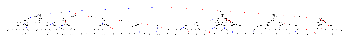

In [15]:
xgb_clf = tuned_classifiers['xgboost']
xgb.plot_tree(tuned_classifiers['xgboost'])
dot_data_xg = xgb.to_graphviz(tuned_classifiers['xgboost'])
graph = graphviz.Source(dot_data_xg)  
graph.render("xgb_tree")

In [19]:
xgb_clf.objective

'multi:softprob'

In [65]:
tr_xg = tuned_classifiers['xgboost'].estimators_[100].tree_
print(f"num_nodes in tree {tr_xg.node_count}")
print(tr_xg.value.shape)
# print(tr.n_node_samples)
print(tr_xg.value[0])
print(tr_xg.n_node_samples[0])
print(tr_xg.__dir__())

AttributeError: 'XGBClassifier' object has no attribute 'estimators_'

In [32]:
# tuned_classifiers['xgboost'].__dir__()

In [66]:
print(tuned_classifiers['xgboost'].n_estimators)
tuned_classifiers['xgboost'].get_booster()

1000


In [73]:
arr = np.array([1,2,3])

In [77]:
arr.take([1, 0, 2])

array([2, 1, 3])

# Submission


**Use the best classifier to predict over the given train set.**

In [ ]:
X_test_for_submission,_,_  = extract_features(test_set_df, ts_handling_scheme='create_x')
scaler_submission = preprocessing.StandardScaler().fit(X)
X_scaled = scaler_submission.transform(X)
X_test_for_submission_scaled = scaler_submission.transform(X_test_for_submission)

In [ ]:
# Now apply on provided test set.
y_test_predicted = best_classifier.predict(X_test_for_submission_scaled)
res_df = pd.DataFrame( { 'label' : y_test_predicted, 'patient_id' : test_set_df.groupby('patient_id').nth(0).index.values})
res_df.to_csv("clew_assignment_submission_matan.csv")


# Concluding comments

* This work consists of:
    -  EDA and data visualizations 
    - Feature extraction 
    - Model training and CV test
    - Evaluation (on the training set)
        - Feature importance
        - Recall/Precision and F1
        - Confusion matrix 


* I've used 3 classifiers: SVM with gaussian kernal, random forest and xgboost. Random forest performed best. Initially I've tried simpler classifiers: LogisticRegression, DecisionTree and KNN, which yielded lower performance metrics. I've omitted them in order not to overload this work.


* Things can always be improved. Optional such improvements:
 - Produce additional features, such as: intersection of a patient timeseries, average distane between two series, 0 or other level crossings. I've planned to do so, but in view of the high resulting performance I've found this redundant.
 - Weigh signals based on their duration (a signal of 4 timestamps is less indicative than a 30 samples one). Additionally - apply classification on only the subset of signals with more than M timestamp and show scores over this set. In view of the features importance, indicating that the intercepts of each of the signals are the more significat ones, I haven't pursued this direction. 
 
This has been a good learning opportunity for me - hope you like the result...

Matan. 

# Interview preparation

Q. Why random forest went better than XGboost?

A. One possibility: ensemble methods work well with fully developed, complex trees, whereas boosting works better with small trees. When working with a single tree, as well as doing the grid search over the forest, I saw that the trees tended to be large - maybe that's the reason. After revising: when adding n_estimators to cv grid - xgboost did better.

Q. Explain the general principles behind each of the schems you've chosen to work with, and why you've chosen to work with them

A. In general, I've chosen to work with methods which don't require special treatment of imbalanced, multiple classes classification.
- SVM: Two main characteristics:
  1. Constructs the decision boundary so that it maximizes the minimal distance between instances of classes. The exact behavior depends on the regularization parameter.
  2. Using kernels enables mapping of the problem to higher dimensions, in which the points are linearly separable.
  3. The decision boundary is determined based on the support vectors, or the classes datapoints at nearest to the boundary (and are not affected by interenal points). This can make SVM susceptible to highly imbalanced data, when the rare class samlples don't include enough samples from the distribution's tail. In our case, there was no extreme imbalance, thus a mild tail sampling can be compensated by increasing the regularization parameter (thus enforcing each sample to be within the boundary). It's also possible to adjust the regularization parameter per class by [multiplying it by the class proportion](https://machinelearningmastery.com/cost-sensitive-svm-for-imbalanced-classification/)
  4. In general, if there's enough data to capture the distribution - imbalance doesn't have a significant effect.
- Random forest:

 1. In general, trees can perform multiclass classification inherently.
 2. [A paper on how to work with random forest and imbalanced data](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf) 

- XGboost:
 - [Dealing with imbalanced data]: (https://machinelearningmastery.com/xgboost-for-imbalanced-classification/) (basically weighing so that the gradient is larger for errors due to the minority class )

In [35]:
x = np.array( [1,2,3])
y = np.array([3,4,5])
print(np.correlate(x,y))

[26]


In [38]:
(x).dot(y)

26